<a href="https://colab.research.google.com/github/mikhpo/ds-for-non-ds/blob/1-%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5-%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5-%D0%BA-23-%D0%BC%D0%B0%D1%8F/notebooks/credit_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Решение задачи кредитного скоринга

Группа 1:
*   Поляков Михаил Юрьевич
*   Томилин Виктор Александрович
*   Макаров Никита Игоревич

[Репозиторий проекта](https://github.com/mikhpo/ds-for-non-ds) в GitHub.





## Импорт библиотек и настройка среды

Данные хранятся в базе данных PostgreSQL в Yandex Cloud. Для подключения к PostgreSQL-кластеру в Yandex Cloud необходимо загрузить SSL-сертификат.

In [1]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-05-20 19:30:57--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-05-20 19:30:57 (553 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



Все библиотеки импортированы в данном блоке в следующем порядке:
1. Модули стандартной библиотеки
2. Сторонние модули из каталога PyPI

In [2]:
import warnings

import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import display

In [3]:
warnings.filterwarnings("ignore") # игнорировать предупреждения фильтрации
plt.style.use("default") # установка стиля графиков matplotlib

## Получение и сохранение данных

Получение данных из таблицы `credit_scoring` в базе данных `db_clients` из PostgreSQL-кластера в Yandex Cloud.

In [4]:
# Создание подключения к базе данных.
conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

In [5]:
# Чтение данных из таблицы SQL-запросом и создание датафрейма Pandas.
query = "SELECT * from public.credit_scoring"

data = pd.read_sql_query(query, conn)

conn.close()

Сохранение данных в формате CSV.

In [6]:
data.to_csv("credit_scoring.csv", index=False)

## Разведочный анализ и подготовка данных

Описание данных:
* SeriousDlqin2yrs: Клиент имел просрочку 90 и более дней - целевая переменная.
* RevolvingUtilizationOfUnsecuredLines: Общий баланс средств (total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits).
* age: Возраст заемщика
* NumberOfTime30-59DaysPastDueNotWorse: Сколько раз за последние 2 года наблюдалась просрочка 30-59 дней.
* DebtRatio: Ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход.
* MonthlyIncome: Ежемесячный доход.
* NumberOfOpenCreditLinesAndLoans: Количество открытых кредитов (напрмер, автокредит или ипотека) и кредитных карт.
* NumberOfTimes90DaysLate: Сколько раз наблюдалась просрочка (90 и более дней).
* NumberRealEstateLoansOrLines: Количество кредиов (в том числе под залог жилья)
* RealEstateLoansOrLines: Закодированное количество кредитов (в том числе под залог жилья) - чем больше код буквы, тем больше кредитов
* NumberOfTime60-89DaysPastDueNotWorse: Сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней.
* NumberOfDependents: Количество иждивенцев на попечении (супруги, дети и др).
* GroupAge: закодированная возрастная группа - чем больше код, тем больше возраст.

In [7]:
display(data)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0,A,c
1,0,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0,A,b
2,1,0.025656,38.0,0,0.475841,3000.0,7,0,0,2.0,A,c
3,0,0.075427,32.0,0,0.085512,7916.0,6,0,0,0.0,A,b
4,0,0.046560,58.0,0,0.241622,2416.0,9,0,0,0.0,A,d
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.977899,63.0,0,517.000000,NaN,5,0,1,0.0,A,d
149996,0,0.025449,58.0,0,0.253855,15500.0,7,0,0,2.0,A,d
149997,0,0.058001,83.0,0,0.013997,5000.0,6,0,0,0.0,A,e
149998,0,0.071273,42.0,0,0.008638,6945.0,3,0,0,1.0,A,c


### Описательная статистика набора данных

Технические параметры набора данных.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   135155 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 9   NumberOfDependents                    146076 non-null  float64
 10  RealEstateLoansOrLines                150000 non-null  object 
 11  

Общая описательная статистика.

In [9]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,135155.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.293618,0.421033,353.005076,6.670221e+03,8.452760,0.265973,0.240387,0.757222
std,0.249746,249.755371,14.772577,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,98.000000,20.000000


Статистика категориальных признаков.

In [10]:
data.describe(include='object')

,RealEstateLoansOrLines,GroupAge
count,150000,150000
unique,5,5
top,A,d
freq,140048,47268


Изучим сбалансированность набора данных по признаку **age**.

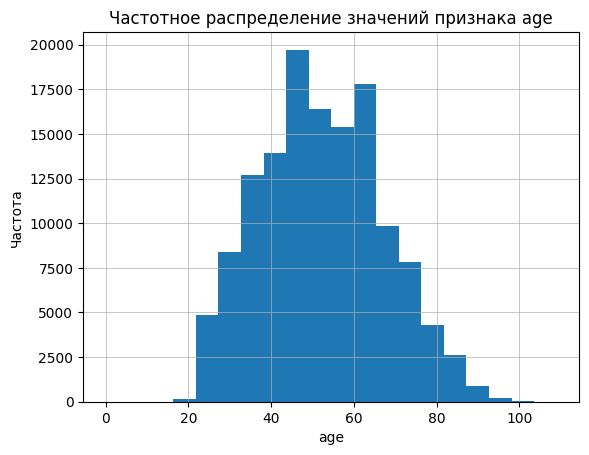

In [11]:
plt.hist(data["age"], bins=20)
plt.xlabel("age")
plt.ylabel("Частота")
plt.xticks(rotation="horizontal")
plt.title("Частотное распределение значений признака age")
plt.grid(linewidth=0.5)
plt.show()

### Распределение целевой переменной

Целевая переменная - поле **SeriousDlqin2yrs** - имел ли клиент просрочку 90 или более дней. Представляет собой категориальный признак, принимающий значения 1 и 0.

In [12]:
pivot_data = pd.pivot_table(data, index="SeriousDlqin2yrs", aggfunc={"SeriousDlqin2yrs": "count"})
pivot_data.rename(columns={"SeriousDlqin2yrs": "count"}, inplace=True)
pivot_data["share"] = pivot_data["count"]/len(data)
display(pivot_data)

,count,share
SeriousDlqin2yrs,,
0,139974,0.93316
1,10026,0.06684


Наблюдается существенный дисбаланс в распределении целевых значений. Визуализируем этот дисбаланс.

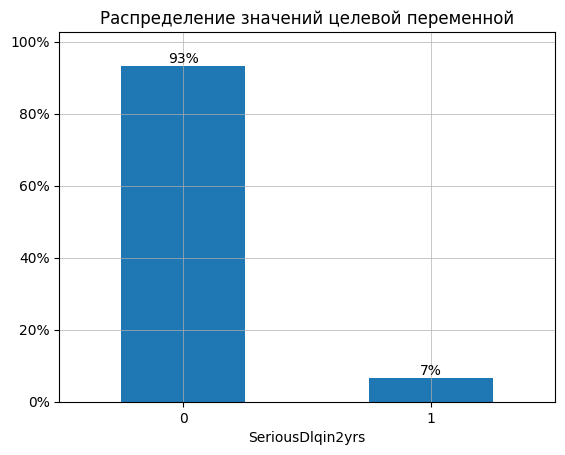

In [13]:
fig, ax = plt.subplots()
ax = pivot_data["share"].plot(kind="bar")
ax.grid(linewidth=0.5)
ax.bar_label(ax.containers[0], fmt="{:.0%}")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title("Распределение значений целевой переменной")
plt.xticks(rotation="horizontal")
plt.margins(0.1, 0.1)
plt.show()

### Обработка пропусков

Определим столбцы с пропусками.

In [14]:
data.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                     14845
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
RealEstateLoansOrLines                      0
GroupAge                                    0
dtype: int64

Пропуски обнаружены в полях **age**, **MonthlyIncome**, **NumberOfDependents**. Значения в этих полях числовые - следовательно, их можно заменить средними и медианными значениями. Воспользуемся медианными значениями, чтобы избежать влияния статистических выбросов.

In [15]:
for field in ("age", "MonthlyIncome", "NumberOfDependents"):
  median = data[field].median()
  print(f"Медианное значение поля {field} составляет {median}")
  data[field] = data[field].fillna(median)

Медианное значение поля age составляет 52.0
Медианное значение поля MonthlyIncome составляет 5400.0
Медианное значение поля NumberOfDependents составляет 0.0


In [16]:
data.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
RealEstateLoansOrLines                  0
GroupAge                                0
dtype: int64

### Обработка ошибочных значений

Проверим распределение значений у текстовых признаков.

In [17]:
for field in ("RealEstateLoansOrLines", "GroupAge"):
  value_counts = data[field].value_counts()
  print(value_counts)
  print()

A    140048
B      8470
C      1388
D        84
E        10
Name: RealEstateLoansOrLines, dtype: int64

d    47268
e    42930
c    42458
b    17343
a        1
Name: GroupAge, dtype: int64



Все значения текстовых признаков представляют собой буквенный код.

### Взаимосвязь признаков

Проанализируем взаимосвязь между признаками, построив матрицу корреляций.

In [18]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001802,-0.110115,0.125587,-0.007602,-0.017151,-0.029669,0.117175,0.102261,0.046869
RevolvingUtilizationOfUnsecuredLines,-0.001802,1.000000,-0.005429,-0.001314,0.003961,0.006513,-0.011281,-0.001061,-0.001048,0.001193
age,-0.110115,-0.005429,1.000000,-0.059947,0.022807,0.025312,0.140710,-0.057991,-0.054372,-0.204370
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.001314,-0.059947,1.000000,-0.006542,-0.008370,-0.055312,0.983603,0.987005,-0.004590
DebtRatio,-0.007602,0.003961,0.022807,-0.006542,1.000000,-0.018006,0.049565,-0.008320,-0.007533,-0.044476
MonthlyIncome,-0.017151,0.006513,0.025312,-0.008370,-0.018006,1.000000,0.086949,-0.010500,-0.009252,0.066314
NumberOfOpenCreditLinesAndLoans,-0.029669,-0.011281,0.140710,-0.055312,0.049565,0.086949,1.000000,-0.079984,-0.071077,0.074026
NumberOfTimes90DaysLate,0.117175,-0.001061,-0.057991,0.983603,-0.008320,-0.010500,-0.079984,1.000000,0.992796,-0.011962
NumberOfTime60-89DaysPastDueNotWorse,0.102261,-0.001048,-0.054372,0.987005,-0.007533,-0.009252,-0.071077,0.992796,1.000000,-0.012678
NumberOfDependents,0.046869,0.001193,-0.204370,-0.004590,-0.044476,0.066314,0.074026,-0.011962,-0.012678,1.000000


Корреляция признаков с целевой переменной.

In [19]:
def create_corr_data(df):
  """
  Сформировать датафрейм, показывающий корреляцию каждого 
  признака в исходном датафрейме к целевой переменной.
  """
  corr_data = pd.DataFrame()
  for col in data.columns:
    if col != "SeriousDlqin2yrs":
      try:
          new_row = {
              "col": col, 
              "corr": np.corrcoef(data[col], data['SeriousDlqin2yrs'])[0][1]
          }
          corr_data = corr_data.append(new_row, ignore_index=True)
      except:
          pass
  return corr_data

In [20]:
corr_data = create_corr_data(data)
display(corr_data)

,col,corr
0,RevolvingUtilizationOfUnsecuredLines,-0.001802
1,age,-0.110115
2,NumberOfTime30-59DaysPastDueNotWorse,0.125587
3,DebtRatio,-0.007602
4,MonthlyIncome,-0.017151
5,NumberOfOpenCreditLinesAndLoans,-0.029669
6,NumberOfTimes90DaysLate,0.117175
7,NumberOfTime60-89DaysPastDueNotWorse,0.102261
8,NumberOfDependents,0.046869


Наблюдается сильная взаимная корреляция между признаками **NumberOfTimes90DaysLate** и **NumberOfTime60-89DaysPastDueNotWorse**. Удалим второй признак из набора данных, так как первый признак имеет большую корреляцию с целевой переменной. Также удалим признаки **RevolvingUtilizationOfUnsecuredLines** и **DebtRatio**, так как они показывают крайне низкую корреляцию с целевой переменной.

In [21]:
data = data.drop(["NumberOfTime60-89DaysPastDueNotWorse", "RevolvingUtilizationOfUnsecuredLines", "DebtRatio"], axis=1)

In [22]:
corr_data = create_corr_data(data)
display(corr_data)

,col,corr
0,age,-0.110115
1,NumberOfTime30-59DaysPastDueNotWorse,0.125587
2,MonthlyIncome,-0.017151
3,NumberOfOpenCreditLinesAndLoans,-0.029669
4,NumberOfTimes90DaysLate,0.117175
5,NumberOfDependents,0.046869


In [23]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.110115,0.125587,-0.017151,-0.029669,0.117175,0.046869
age,-0.110115,1.000000,-0.059947,0.025312,0.140710,-0.057991,-0.204370
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.059947,1.000000,-0.008370,-0.055312,0.983603,-0.004590
MonthlyIncome,-0.017151,0.025312,-0.008370,1.000000,0.086949,-0.010500,0.066314
NumberOfOpenCreditLinesAndLoans,-0.029669,0.140710,-0.055312,0.086949,1.000000,-0.079984,0.074026
NumberOfTimes90DaysLate,0.117175,-0.057991,0.983603,-0.010500,-0.079984,1.000000,-0.011962
NumberOfDependents,0.046869,-0.204370,-0.004590,0.066314,0.074026,-0.011962,1.000000
